In [187]:
import arcgis
from arcgis.gis import GIS
from arcgis.apps import storymap
from getpass import getpass
from arcgis.features import FeatureLayer
from arcgis.features import FeatureLayerCollection
import pandas as pd
import matplotlib.pyplot as plot
from matplotlib.pyplot import figure
import matplotlib.image as img
import numpy as np

# Create a connection to your portal for publishing (enter your ArcGIS Online 
#  password in the textbox that appears, then hit 'Enter' on your keyboard)
gis = GIS("https://www.arcgis.com", "ezhatcher", getpass())

········


In [188]:
#Define the base template storymap using the item ID -- Hoonah Alaska
seedappItem = gis.content.get("2a51cb9cc9d54b57a52c67d8efdb5eba") #"2a51cb9cc9d54b57a52c67d8efdb5eba"

In [189]:
#Clone the storymap
contentManager = arcgis.gis.ContentManager(gis)
clones = contentManager.clone_items(items=[seedappItem],search_existing_items=False)
clones
clonedStorymap = storymap.JournalStoryMap(clones[0])

In [190]:
#arcgis.geometry for polygon extents

In [191]:
#Use the base feature class that has the listing of communities for which a storymap will be created-- currently, it's the 
#boundaries feature service, which also defines the map extent as the user scrolls through the panels
community_base = gis.content.get("8499c3bc4ff141588f5c9ab1db99b0fb")
find_comm = community_base.layers[0].query(where="CommunityName IS NOT NULL",out_fields="CommunityName").df.CommunityName
community_lst = []
for c in find_comm:
    community_lst.append(c)

In [192]:
#Save the storymap clone using the new community name and information
community = 'Allakaket'
clonedStorymap.save(title=str(community) +" Storymap Test", description="Test cloning script result", tags="Test,Storymap")
sections = clonedStorymap.properties["values"]["story"]["sections"]

In [193]:
#Define the function to access a field within a layer
def access_lyr(content,out_fld):
    base = content.layers
    lyr = base[0]
    topic_data = lyr.query(where="CommunityName = '" + str(community) + "'",out_fields=out_fld)
    return topic_data.df

In [194]:
#Access the URL for the main photo from the Photo Link feature class
photo_base = gis.content.get("6d9d437bbe2d48bfa87b4d9fca41f80d")
find_photo = access_lyr(photo_base,'PhotoLink')
photo_url = find_photo
main_pic = photo_url.PhotoLink[0]
if str(main_pic) == 'None':
    print('There is no picture for ' + str(community))
else:
    print('Picture found for ' + str(community) + ' at ' + str(main_pic))

Picture found for Allakaket at https://dcced.maps.arcgis.com/sharing/rest/content/items/80bb4ec0c7274de980fab95240346ee4/data


In [195]:
#Identify/define the storymap panels
panel_toc = sections[0]
panel_ch = sections[1]
panel_demog = sections[2]
panel_transport = sections[3]
panel_edu = sections[4]
panel_econ = sections[5]
panel_util = sections[6]
panel_ANCSA = sections[7]
panel_contacts = sections[8]

panel_list = []
panel_list.append(panel_demog)
panel_list.append(panel_transport)
panel_list.append(panel_edu)
panel_list.append(panel_econ)
#panel_list.append(panel_util) #problem with bounding box...
#panel_list.append(panel_ANCSA) #problem with bounding box... 
panel_list.append(panel_contacts)


#Modify the main title and photo in the main Table of Contents panel
panel_toc["title"] = '<span style="font-size:40px">' + str(community) + ', Alaska</span>'
if str(main_pic) == 'None':
    panel_toc["media"]["image"]["url"] = "http://dcced.maps.arcgis.com/sharing/rest/content/items/34bf2ca84faa4b258712ed7a5422d0d5/data"
else:
    panel_toc["media"]["image"]["url"] = main_pic
clonedStorymap.save()

True

In [196]:
#Access the webmap and clone the webmap/update map filters
current_webmap = gis.content.get("bdbb441b8b5d4ef2bc1a519c44e49c6b")
wm = arcgis.mapping.WebMap(webmapitem=current_webmap)
wm_properties = {'title':'OpenData_Storymap_' + str(community),'snippet':'Test webmap clone','tags':['dcra','test']}
wm.save(wm_properties,folder='Storymap Webmaps') 
#Find the new webmap and rename it
new_map_search = gis.content.search('OpenData_Storymap_' + str(community), item_type="Web Map")
webmap = new_map_search[0]
new_webmap = webmap.id
#Define the webmap item to access and filter layers
upd_webmap = gis.content.get(new_webmap)
wm_instory = arcgis.mapping.WebMap(webmapitem=upd_webmap)


In [197]:
#UPDATE WEBMAP LAYER FILTERS
#Taxes
wm_instory.layers[0]["layerDefinition"]["definitionExpression"] = "(CommunityName = '" + str(community) +"') AND (RevenueYear = 2016)"

#Employment and Wages
wm_instory.layers[1]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#Income and Poverty
wm_instory.layers[2]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#Municipality Contacts
wm_instory.layers[3]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#School Enrollment
wm_instory.layers[4]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#DCCED Certified Population
wm_instory.layers[5]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#Ferries
wm_instory.layers[6]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#Culture and History
wm_instory.layers[7]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#Boro_REAAs
#wm_instory.layers[8]

#Alaska Airports
wm_instory.layers[9]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#Federally Recognized Tribes Contacts
wm_instory.layers[10]["layers"][0]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#ANCSA Status
wm_instory.layers[11]["layers"][0]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#Census Population Group Layers
wm_instory.layers[12]["layers"][0]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#Alaska Schools
wm_instory.layers[13]["layers"][0]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

#Alaska School Districts
#wm_instory.layers[14]

#Alaska Road System
#wm_instory.layers[15]

#Transportation Airport Hub Role
#wm_instory.layers[16]["layers"][0]["layerDefinition"]["definitionExpression"] = "CommunityName = '" + str(community) + "'"

wm_instory.update()

#Set up filters in the web map to fit the community (Set this kind of thing up once layers are finalized)
#def_expr = "CommunityName = '" + str(community) + "'"
#def_expr2 = "City = '" + str(community) + "'"
#conv2_lyrs = [9, 10, 12]
#for i in range(7):
#    wm_lyrs = wm.layers[i]
#    wm_lyrs["layerDefinition"]["definitionExpression"] = def_expr
#wm.layers[8]['layerDefinition']['definitionExpression'] = def_expr2
#for n in conv2_lyrs:
#    wm_lyrs = wm.layers[n]
#    wm_lyrs["layers"][0]["layerDefinition"]["definitionExpression"] = def_expr
#wm.update()


True

In [198]:
#Set up zoom scale (x max and min, y max and min) for map actions
try:
    bound_expr = "CommunityName LIKE '%" + str(community) + "%'"
    bounds_ft = gis.content.get("8499c3bc4ff141588f5c9ab1db99b0fb").layers[0]
    x_min = bounds_ft.query(where=bound_expr,out_fields='EXT_MIN_X').df.EXT_MIN_X[0]
    x_max = bounds_ft.query(where=bound_expr,out_fields='EXT_MAX_X').df.EXT_MAX_X[0]
    y_min = bounds_ft.query(where=bound_expr,out_fields='EXT_MIN_Y').df.EXT_MIN_Y[0]
    y_max = bounds_ft.query(where=bound_expr,out_fields='EXT_MAX_Y').df.EXT_MAX_Y[0]
except Exception as e:
    print("Exception: " + str(e))

#Function to define the primary zoom scale of each panel based on the minimum bounding envelope feature service
# item id = "8499c3bc4ff141588f5c9ab1db99b0fb" using previously defined zoom scale
def main_extent(p):
    p["media"]["webmap"]["id"] = new_webmap
    ext1 = p["media"]["webmap"]["extent"]
    ext1["xmin"] = x_min
    ext1["xmax"] = x_max
    ext1["ymin"] = y_min
    ext1["ymax"] = y_max
    clonedStorymap.save()

In [199]:
#Update all of the panel webmaps using the new webmap ID
for p in panel_list:
    main_extent(p)

In [200]:
#Adjust community point y-offset (main overview map in Culture History panel)
#wm_instory.layers[5]["layerDefinition"]["drawingInfo"]["renderer"]["symbol"]["yoffset"] = 16

In [201]:
#Access the culture and history from the culture/history feature class (IF THE PANEL ORDER CHANGES, MAKE SURE INDEX STILL APPLIES)
panel_ch["media"]["webmap"]["id"] = new_webmap
ch_ft = gis.content.get("3f99cf21a0da42c4bf8b15632e958df9")
culture_lookup = access_lyr(ch_ft,'CommunityCulture')
culture = culture_lookup.CommunityCulture[0]
history_lookup = access_lyr(ch_ft,'CommunityHistory')
history = history_lookup.CommunityHistory[0]

In [202]:
#Populate the panel with the new culture history info
panel_ch["content"] = '<style type="text/css">.dcra-blue {\n     display: inline-block;\n     background-color: #005e95;\n     border-color: #005e95 !important;\n     color: #fff !important;\n     padding: 0px 4px;\n     border-radius: 0px;\n}\n</style>\n<p><a class="dcra-blue" data-storymaps="MJ-ACTION-1524783785796" data-storymaps-type="navigate">Back to Table of Contents</a></p>\n\n<p>&nbsp;<p>'+ history + '&nbsp;</p>\n\n<p>\n\n<p>&nbsp;<p>'+ culture + '&nbsp;</p>\n'
panel_ch["media"]["webmap"]["altText"] = 'Map showing the location of ' + str(community) + ', Alaska in the context of the state and borough/REAA boundaries.'
clonedStorymap.save()

True

In [203]:
#Demographics Panel Updates
#Update the zoom extent for the demographics panel map action (tied to 'Historic Census' button)
panel_demog["contentActions"][1]["media"]["webmap"]["id"] = new_webmap
panel_demog["media"]["webmap"]["id"] = new_webmap
census_lyr = gis.content.get("920dba8f13844c69a7589f7aaaadbcf4")
census_lyr.layers[0]
census_data = census_lyr.layers[0].query(where="CommunityName = '" + str(community) + "'",out_fields=('Census1880,Census1890,Census1900,Census1910,Census1920,Census1930,Census1940,Census1950,Census1960,Census1970,Census1980,Census1990,Census2000,Census2010'))
point_geom = census_data.df.SHAPE
point_x = point_geom[0]["x"]
point_y = point_geom[0]["y"]

panel_demog["media"]["webmap"]["altText"] = 'Map showing aerial imagery of ' + str(community) + ', Alaska and a pop-up box displaying current and historic DCCED certified population counts from 2011 to present.'

clonedStorymap.save()

True

In [204]:
###DEMOGRAPHICS PANEL###
#Update popup extents
panel_demog["media"]["webmap"]["popup"]["fieldName"] = 'CommunityName'
panel_demog["media"]["webmap"]["popup"]["fieldValue"] = str(community)
panel_demog["media"]["webmap"]["popup"]["anchorPoint"]["x"] = point_x
panel_demog["media"]["webmap"]["popup"]["anchorPoint"]["y"] = point_y

#Update the main demographics panel popup
demog_histpopup = panel_demog["contentActions"][1]["media"]["webmap"]["popup"]
demog_histext = panel_demog["contentActions"][1]["media"]["webmap"]["extent"]

#Update historic census map action extent
demog_histext["xmin"] = x_min
demog_histext["xmax"] = x_max
demog_histext["ymin"] = y_min
demog_histext["ymax"] = y_max

#Update historic census popup data and extent
demog_histpopup["fieldName"] = 'CommunityName'
demog_histpopup["fieldValue"] = str(community)
demog_histpopup["x"] = point_x
demog_histpopup["y"] = point_y
demog_histpopup["anchorPoint"]["x"] = point_x
demog_histpopup["anchorPoint"]["y"] = point_y
clonedStorymap.save()

True

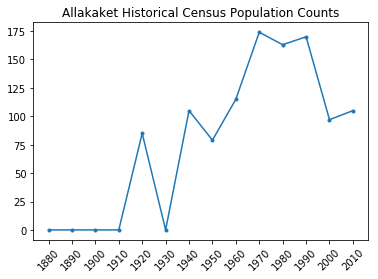

b'iVBORw0KGgoAAAANSUhEUgAAAbAAAAEgCAYAAADVKCZpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz\nAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBo\ndHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzs3Xd8VFX+//HXzKSTXkkjFQKEEkgI\niAooCyuIWECkWBCFtf3Wta5lV/HrLuq6trUsm10WERHUtVBEEJGqQggQINQQ0hNImfQ+M/f3R8xI\nIEDKTGYm+TwfDx6PZDL33E/uDPPOPefcc1WKoigIIYQQNkZt6QKEEEKIzpAAE0IIYZMkwIQQQtgk\nCTAhhBA2SQJMCCGETZIAE0IIYZMkwIQQQtgkCTAhhBA2SQJMCCGETZIAE0IIYZMkwIQQQtgkCTAh\nhBA2SQJMCCGETZIAE0IIYZMkwIQQQtgkCTAhhBA2SQJMCCGETZIAE0IIYZMkwLrZ/Pnz+dOf/gTA\n9u3bCQkJadd2H374Iddcc02n9hkeHs7333/fqW1NITY2lu3bt5t9Pzk5Obi6uqLX67vUzoQJE/jP\nf/5joqpER97nbXnggQd4+eWXTViR6CkkwMxkwoQJeHl50dDQYOlSOm3x4sXceeedl31OW+F4Ydge\nPXqUCRMmXLadrKwsVCoVOp2u0/X269eP6upqNBpNp9toj1OnTnH77bfj6+uLh4cHw4YN48033+xy\ncHaH8PBwnJ2dcXV1JSAggHvvvZfq6mpLl2XU1h9qS5cu5c9//rNZ9mep1/L8P2RF50mAmUFWVha7\ndu1CpVKxbt06S5fTK3Ql+DoiIyOD0aNHExoaypEjR6ioqODzzz8nJSWFqqqqbqmhq9avX091dTUH\nDhxg3759/OUvf7F0SRbRE17L3k4CzAw++ugjxowZw/z581mxYkW7t3v11VeJio

True

In [243]:
###DEMOGRAPHICS PANEL###
#Historical census plot for demographics panel
import base64
census_base = gis.content.get("3902789711f744f3b7f9cbd51dee6021")
pop_df = access_lyr(census_base,'CensusPopulation, CensusYear')
y = pop_df.CensusPopulation
x = pop_df.CensusYear

fig = plot.figure()
ax = plot.subplot(111)
ax.plot(x, y, marker='.', label='Population Size 1880-Present')
plot.xticks(rotation = 45)
plot.title(str(community) + ' Historical Census Population Counts')
plot.show()
image = (str(community) + '_censusplot.png')
fig.savefig(image)
open_image = open(image, 'rb')
image_read = open_image.read()
image_64_encode = base64.encodebytes(image_read)
print(str(image_64_encode))
embed_plt = "<div><img style='display:block;width:400px;height:325px;' src='data:<MIMETYPE>;base64,<BASE64_ENCODED_IMAGE><img src='data:image/png;base64," + str(image_64_encode) + "'></div>"
# encode as base64 string to embed it

panel_demog["content"] = '<style type="text/css">.dcra-blue {\n     display: inline-block;\n background-color: #005e95;\n     border-color: #005e95 !important;\n     color: #fff !important;\n     padding: 0px 4px;\n     border-radius: 0px;\n}\n</style>\n<p><a class="dcra-blue" data-storymaps="MJ-ACTION-1524783883308" data-storymaps-type="navigate">Back to Table of Contents</a></p>\n\n<p>&nbsp;</p>\n\n<p>Every June the Commissioner of the Department of Commerce Community Economic Development certifies community population figures. The most recent figures are displayed here.&nbsp;</p>\n\n<p>&nbsp;</p>\n\n<p><a class="btn-orange" data-storymaps="MJ-ACTION-1532625427902" data-storymaps-type="media" xmlns="http://www.w3.org/1999/xhtml">Historical Census</a>&nbsp;population for the community also provide a century\'s worth of change in this community.&nbsp;</p>\n\n<p> ' + str(embed_plt) +'&nbsp;</p>\n\n<p>More information about demographics can be found <a href="http://DCCED.maps.arcgis.com/apps/webappviewer/index.html?id=577407acfbc6433389006d099cb25971" target="_blank">here.&nbsp;</a></p>\n'

clonedStorymap.save()

In [225]:
###TRANSPORTATION PANEL###
#Update panel text using transportation overview feature class (item id = "2076ce8b6744430880e1c8ab923cd720")
find_text = gis.content.get("2076ce8b6744430880e1c8ab923cd720")
access_text = find_text.layers[0].query(where="CommunityName = '" + str(community) + "'",out_fields='Description').df

#Create airport listing table in panel
hub_role_base = gis.content.get("d373c8a5ff0c43cf9cb505c63e0c5f4d")
arpt_data = access_lyr(hub_role_base,'EntityName')
#arpt_tbl = arpt_data.to_html(columns=["EntityName", "Hub", "Role", "AirportCode_1"]).replace('EntityName', 'Airport')
#tbl2 = arpt_tbl.replace('AirportCode_1', "Airport Code")
#tbl_FINAL = tbl2.replace('<th>','<th bgcolor="5C96CA">')
if str(arpt_data == 'Empty DataFrame\nColumns: []\nIndex: []'):
    print("There are no public use airports in " + str(community))
    panel_transport["content"] = '<style type="text/css">.dcra-blue {\n     display: inline-block;\n     background-color: #005e95;\n     border-color: #005e95 !important;\n     color: #fff !important;\n     padding: 3px 8px;\n     border-radius: 5px;\n}\n</style>\n<style type="text/css">.btn-orange {\n    display: inline-block;\n    background-color: #f0ad4e;\n    border-color: #f0ad4e !important;\n    color: #fff !important;\n    padding: 0px 2px;\n    border-radius: 12px;\n}\n</style>\n<p><a class="dcra-blue" data-storymaps="MJ-ACTION-1524784108786" data-storymaps-type="navigate">Back to Table of Contents</a></p>\n\n<p>&nbsp;</p>\n\n<p>' + access_text.Description[0] + '</p>\n\n<p>&nbsp;</p>\n\n<p>&nbsp;</p>\n\n<p>&nbsp;</p>\n\n<p>More detailed information about Transportation in Alaska can be found <a href="http://DCCED.maps.arcgis.com/apps/webappviewer/index.html?id=3de3ebccbb6b4ba8a9c64609e96199ba" target="_blank"><strong>here</strong></a>.&nbsp;</p>\n'
else:
    def airport_lst(airports):
        arpt_listing = ["<table border = '1'><tr><th width='50%'>Airport</th><th width='15%'>Hub</th><th width='15%'>Role</th><th width='20%'>Airport Code</th></tr><tbody>"]
        for a in airports:
            airport_data = hub_role_base.layers[0].query(where="EntityName = '" + str(a) + "'",out_fields='EntityName, Hub, Role, AirportCode_1')
            airport = airport_data.df.EntityName[0]
            hub_item = airport_data.df.Hub[0]
            role_item = airport_data.df.Role[0]
            arpt_code = airport_data.df.AirportCode_1[0]
            arpt_listing.append("<tr><td>" + a + "</td><td> " + str(hub_item) + "</td><td> " + str(role_item) + "</td><td>" + str(arpt_code) + "</td><td>")
        arpt_listing.append("</tbody></table>")
        return(' '.join(arpt_listing))
    airport_lst(airports)
    panel_transport["content"] = '<style type="text/css">.dcra-blue {\n     display: inline-block;\n     background-color: #005e95;\n     border-color: #005e95 !important;\n     color: #fff !important;\n     padding: 3px 8px;\n     border-radius: 5px;\n}\n</style>\n<style type="text/css">.btn-orange {\n    display: inline-block;\n    background-color: #f0ad4e;\n    border-color: #f0ad4e !important;\n    color: #fff !important;\n    padding: 0px 2px;\n    border-radius: 12px;\n}\n</style>\n<p><a class="dcra-blue" data-storymaps="MJ-ACTION-1524784108786" data-storymaps-type="navigate">Back to Table of Contents</a></p>\n\n<p>&nbsp;</p>\n\n<p>' + access_text.Description[0] + '</p>\n\n<p>&nbsp;</p><p>Click on the icons in the map to see specific information about each airport or ferry terminal.</p>\n\n<p>&nbsp;</p>\n\n<p>' + str(airport_lst(airports)) + '</p><p>&nbsp;</p>\n\n<p>More detailed information about Transportation in Alaska can be found <a href="http://DCCED.maps.arcgis.com/apps/webappviewer/index.html?id=3de3ebccbb6b4ba8a9c64609e96199ba" target="_blank"><strong>here</strong></a>.&nbsp;</p>\n'
clonedStorymap.save()

There are no public use airports in Allakaket


True

In [208]:
###EDUCATION PANEL###
#Popups if we can iteratively create map actions per school in each community...
#panel_edu["contentActions"][1]["media"]["webmap"]["id"] = new_webmap
#popup_ext = panel_edu["contentActions"][1]["media"]["webmap"]["extent"]
#popup_ext["xmin"] = x_min
#popup_ext["xmax"] = x_max
#popup_ext["ymin"] = y_min
#popup_ext["ymax"] = y_max
#clonedStorymap.save()

#CUSTOM POPUP
ak_schools = gis.content.get("1f8928a4bae646ef884be3b6a0b8bae8")
community_sch_lst = access_lyr(ak_schools,'EntityName,PhysicalAddress,PhysicalCity,PhysicalZip')
output = str(ak_schools.layers[0].query(where="CommunityName = '" + str(community) + "'",out_fields = "EntityName").df)
if output == 'Empty DataFrame\nColumns: []\nIndex: []':
    print("There are no schools in " + str(community))
    panel_edu["content"] = '<p>&nbsp;</p>\n\n<p>\n<style type="text/css">.blue {\n     display: inline-block;\n     background-color: #3182bd;\n     border-color: #3182bd !important;\n     color: #fff !important;\n     padding: 1px 3px;\n     border-radius: 12px;\n</style>\n<style type="text/css">.dcra-blue {\n     display: inline-block;\n     background-color: #005e95;\n     border-color: #005e95 !important;\n     color: #fff !important;\n     padding: 3px 8px;\n     border-radius: 5px;\n</style>\n</p>\n<p><a class="dcra-blue" data-storymaps="MJ-ACTION-1524785467480" data-storymaps-type="navigate">Back to Table of Contents</a><br>\n<style type="text/css">\n</style>\n</p>\n\n<p>&nbsp;</p>\n\n<p>There are no schools open in' + str(community) + '</p><p>&nbsp;</p>\n\n<p>For more information about Alaska schools and education, click <a href="http://DCCED.maps.arcgis.com/apps/webappviewer/index.html?id=cff461c2397d4c66ae2c28dbfb62319f" target="_blank">here</a>.</p>\n'
else:
    schools = community_sch_lst.EntityName
    def school_lst(entities):
        school_list = ["<table border = '1'><tr><th width='45%'>School</th><th width='45%'>Address</th><th width='10%'>Zip Code</th></tr><tbody>"]
        for e in entities:
            school_data = ak_schools.layers[0].query(where="EntityName = '" + str(e) + "'",out_fields='EntityName,PhysicalAddress,PhysicalCity,PhysicalZip')
            address = school_data.df.PhysicalAddress[0]
            city = school_data.df.PhysicalCity[0]
            zipcode = school_data.df.PhysicalZip[0]
            print(e, address, city, zipcode)
            school_list.append("<tr><td>" + str(e) + "</td><td>" + str(address) + "</td><td>" + str(zipcode) + '</td></tr>')
        school_list.append("</tbody></table>")
        return(' '.join(school_list))

    school_tbl = school_lst(schools)

    ###EDUCATION PANEL###
    #Update panel schools listing
    sch_ref = panel_edu["contentActions"][1]["media"]["webmap"]["popup"]["layerId"]
    find_sch_lyr = gis.content.search("Alaska PK-12", item_type = "Map Service")
    schools = find_sch_lyr[0].layers[0].query(where="CommunityName = '" + str(community) + "'",out_fields='EntityName')
    school_dist = find_sch_lyr[0].layers[0].query(where="EntityName = '" + str(schools.df.EntityName[0]) + "'", out_fields='SchoolDistrict').df.SchoolDistrict[0]

    panel_edu["content"] = '<p>\n<style type="text/css">.blue {\n     display: inline-block;\n     background-color: #3182bd;\n     border-color: #3182bd !important;\n     color: #fff !important;\n     padding: 1px 3px;\n     border-radius: 12px;\n</style>\n<style type="text/css">.dcra-blue {\n     display: inline-block;\n     background-color: #005e95;\n     border-color: #005e95 !important;\n     color: #fff !important;\n     padding: 3px 8px;\n     border-radius: 5px;\n</style>\n</p>\n \n<p><a class="dcra-blue" data-storymaps="MJ-ACTION-1524785467480" data-storymaps-type="navigate">Back to Table of Contents</a><br>\n<style type="text/css">\n</style>\n</p>\n\n<p>&nbsp;</p>\n\n<p>&nbsp;</p>\n\n<p>&nbsp;</p>\n\n<p>' + str(community) + ' schools are part of ' + str(school_dist) + '. </p>\n\n<ul>\n\t <p>&nbsp;</p>\n\n <p><div style="text-align: center,">' + str(school_tbl) + '</p></div><p>&nbsp;</p>\n\n<p>Click each school in the map to see enrollment information from 2012 to present.</p><p>&nbsp;\n\n</p><p>For more information about Alaska schools and education, click <a href="http://DCCED.maps.arcgis.com/apps/webappviewer/index.html?id=cff461c2397d4c66ae2c28dbfb62319f" target="_blank">here</a>.</p>\n'

    clonedStorymap.save()
    

Allakaket School 3rd Street Complex Allakaket 99720


In [209]:
ak_schools = gis.content.get("1f8928a4bae646ef884be3b6a0b8bae8")
community_sch_lst = access_lyr(ak_schools,'EntityName,PhysicalAddress,PhysicalCity,PhysicalZip')
schools = community_sch_lst.EntityName
community_sch_lst

,EntityName,OBJECTID,PhysicalAddress,PhysicalCity,PhysicalZip,SHAPE
0,Allakaket School,412,3rd Street Complex,Allakaket,99720,"{'x': -16992305.2163, 'y': 10032738.481299996,..."


In [210]:
panel_edu["contentActions"][1]["media"]["webmap"]["id"] = new_webmap

In [211]:
###CONTACTS PANEL###
#Find Municipality Contact Information
contacts_fl_id = gis.content.search(query="title:Municipality Contacts", item_type="Feature Layer")[0].id
contacts_lyr = gis.content.get(contacts_fl_id)
contact_info = contacts_lyr.layers[0].query(where="EntityName LIKE '%" + str(community) + "%'",out_fields='EntityName,Address,City,Zip,Phone,Fax,Website,Email')
contact_info.df


,Address,City,Email,EntityName,Fax,OBJECTID,Phone,Website,Zip,SHAPE
0,PO Box 30,Allakaket,aet99720@gmail.com,City of Allakaket,9079682241,13,9079682424,None,99720,"{'x': -152.64948048199997, 'y': 66.56004842400..."


In [212]:
###CONTACTS PANEL###
#Write municipality info to table
output = str(contact_info.df)
if output == 'Empty DataFrame\nColumns: []\nIndex: []':
    print(str(community) + ' is not a municipality. No municipal contact info will be written to panel.')
    panel_contacts["content"] = '<style type="text/css">.dcra-blue {\n     display: inline-block;\n     background-color: #005e95;\n     border-color: #005e95 !important;\n     color: #fff !important;\n     padding: 0px 4px;\n     border-radius: 0px;\n}\n</style>\n<p><a class="dcra-blue" data-storymaps="MJ-ACTION-1524783785796" data-storymaps-type="navigate">Back to Table of Contents</a></p>\n\n<p>&nbsp;</p>\n\n<p>To find all community contacts and to download mailing labels visit the <a href="http://dcced.maps.arcgis.com/apps/webappviewer/index.html?id=148ae1328f9549acb46cfa80366ed37e/data" target="_blank">Contacts Directory</a>.&nbsp;</p>\n'
else: 
    def muni_c_lst(info):
        muni_contact = []
        address = info.df.Address[0]
        city = info.df.City[0]
        zipcode = info.df.Zip[0]
        phone1 = info.df.Phone[0]
        phone = str(phone1[0:3] + '-' + phone1[3:6] + '-' + phone1[6:11])
        fax1 = info.df.Fax[0]
        fax = str(fax1[0:3] + '-' + fax1[3:6] + '-' + fax1[6:11])
        website = info.df.Website[0]
        email = info.df.Email[0]
        print(address, city, zipcode, phone, fax, website, email)
        muni_contact.append("<p style='text-align:center'><b>" + str(info.df.EntityName[0]) + '</b></p>')
        muni_contact.append("<p style='text-align:center'>" + str(address) + ", " + str(city) + ", AK" + " " + str(zipcode) + '<p>&nbsp;</p>\n\n')
        muni_contact.append("<p style='text-align:center'>Phone Number: " + str(phone) + '</p>')
        muni_contact.append("<p style='text-align:center'>Fax Number: " + str(fax) + '</p><p>&nbsp;</p>\n\n')
        muni_contact.append("<p style='text-align:center'>Website: " + str(website) + '</p>')
        muni_contact.append("<p style='text-align:center'>" + str(email) + '</p><p>&nbsp;</p>\n\n')
        return(' '.join(muni_contact))

    muni_c_lst(contact_info)
    
    panel_contacts["content"] = '<style type="text/css">.dcra-blue {\n     display: inline-block;\n     background-color: #005e95;\n     border-color: #005e95 !important;\n     color: #fff !important;\n     padding: 0px 4px;\n     border-radius: 0px;\n}\n</style>\n<p><a class="dcra-blue" data-storymaps="MJ-ACTION-1524783785796" data-storymaps-type="navigate">Back to Table of Contents</a></p>\n\n<p>&nbsp;</p>\n\n<div> '+ str(muni_c_lst(contact_info)) + '<p>To find all community contacts and to download mailing labels visit the <a href="http://dcced.maps.arcgis.com/apps/webappviewer/index.html?id=148ae1328f9549acb46cfa80366ed37e/data" target="_blank">Contacts Directory</a>.&nbsp;</p>\n'
    clonedStorymap.save()

PO Box 30 Allakaket 99720 907-968-2424 907-968-2241 None aet99720@gmail.com
PO Box 30 Allakaket 99720 907-968-2424 907-968-2241 None aet99720@gmail.com


In [213]:
panel_demog

{'title': '<span style="font-size:26px">Demographics</span>',
 'content': '<style type="text/css">.dcra-blue {\n     display: inline-block;\n background-color: #005e95;\n     border-color: #005e95 !important;\n     color: #fff !important;\n     padding: 0px 4px;\n     border-radius: 0px;\n}\n</style>\n<p><a class="dcra-blue" data-storymaps="MJ-ACTION-1524783883308" data-storymaps-type="navigate">Back to Table of Contents</a></p>\n\n<p>&nbsp;</p>\n\n<p>Every June the Commissioner of the Department of Commerce Community Economic Development certifies community population figures. The most recent figures are displayed here.&nbsp;</p>\n\n<p>&nbsp;</p>\n\n<p><a class="btn-orange" data-storymaps="MJ-ACTION-1532625427902" data-storymaps-type="media" xmlns="http://www.w3.org/1999/xhtml">Historical Census</a>&nbsp;population for the community also provide a century\'s worth of change in this community.&nbsp;</p>\n\n<p> <figure><img src=Allakaket_censusplot.png width=\'300\' height=\'225\'></fig